In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import time
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from copy import deepcopy

In [3]:
from spacetime import SpaceTime
from spacetime.simulate import Simulator
# from spacetime.models_att2 import MLPEncoder, MLPDecoder, AutoEncoder
from spacetime.training_att import LagrangeLoss, ActionOpt
from spacetime.training_att import train, truth_evaluation
from spacetime.utils_att import Parameters, spacetime_mutilator, graph_clipper
from spacetime.sampler import NodeData, GraphSampler

In [4]:
node_dict = {0:[0], 1:[1], 2:[2], 3:[3]}
node_list = [j for i in node_dict.values() for j in i]
n_nodes = sum(map(len, node_dict.values()))
from spacetime.training_att import h_A, h_A_timed

sim_params = Parameters(graph_type='erdos-renyi', graph_degree=2, edge_types=2, 
                        sem_type='nonlinear_2', x_dims=1, sem_noise='linear-gauss', 
                        noise_scale = 0.6, sample_size=7500, seed=42)

mod_params = Parameters(n_nodes=n_nodes, x_dims=1, h_dims=64, z_dims=1, graph_threshold=0.4)

trn_params = Parameters(batch_size=100, epochs=5)

opt_params = Parameters(constraint=lambda x: h_A_timed(x, node_dict),
                        lr=3e-3, l=1e-2, c=1.0, h=np.inf, tau=1e-10, 
                        max_iters=50, h_tol=1e-8)

simulating an ordered 2-degree erdos-renyi dag with range (0.5, 2.0) (seed 101)


array([[ 0.        ,  1.84041962, -1.58231579,  0.78490843],
       [ 0.        ,  0.        ,  0.7728386 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

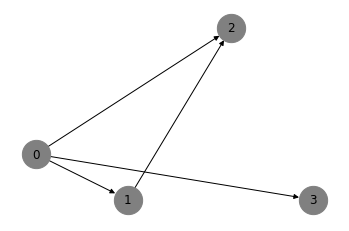

In [5]:
g = SpaceTime.from_spacetime(node_dict, simulate=True,
                             degree=sim_params.graph_degree, 
                             graph_type=sim_params.graph_type, 
                             w_range=(0.5,2.0), force_positive=True, seed=101)
g.graph.edges[(0,1)]['weight'] *= 1.0
g.graph.edges[(0,2)]['weight'] *= -1.0
g.graph.edges[(0,3)]['weight'] *= 1.0
g.graph.edges[(1,2)]['weight'] *= 1.0
g.show_adj()
g.draw_graph()

In [42]:
col_plot_dict = {0:(2,1), 1:(2,0), 2:(3,0), 3:(1,0)}
mutilate = 1
observe = 2
latent = 0

In [7]:
g.data = Simulator.sem(graph=g.graph, n=sim_params.sample_size, x_dims=sim_params.x_dims, 
                       sem_type=sim_params.sem_noise, linear_type=sim_params.sem_type, 
                       noise_scale=sim_params.noise_scale, seed=sim_params.seed)
train_loader, test_loader = g.torch_loader(g.data, trn_params.batch_size)

simulating 7500 samples from a linear-gauss sem with nonlinear_2 causal effects


In [8]:
####################################################################
### Ripped heavily from https://github.com/fishmoon1234/DAG-GNN
####################################################################

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

_EPS = 1e-10

class AutoEncoder(nn.Module):
    def __init__(self, mod_params):
        super(AutoEncoder, self).__init__()
        self.embedder = LinearBlock(mod_params.x_dims, mod_params.h_dims, mod_params.z_dims).double()
        self.debedder = LinearBlock(mod_params.z_dims, mod_params.h_dims, mod_params.x_dims).double()
        self.semblock = SEMBlock(mod_params.n_nodes, mod_params.z_dims).double()
        self.ennoiser = LinearBlock(mod_params.z_dims, int(mod_params.h_dims), mod_params.z_dims).double()
        self.denoiser = LinearBlock(mod_params.z_dims, int(mod_params.h_dims), mod_params.z_dims).double()
    
    def encode(self, x):
#         x = self.embedder(x)
        x, adj, Wa = self.semblock.forward(x)
        z = self.ennoiser(x)
        return z, adj, Wa
    
    def decode(self, z, adj, Wa):
        x = self.denoiser(z)
        x = self.semblock.inverse(x, adj, Wa)
#         x = self.debedder(x)
        return x
    
    def forward(self, x):
        z, adj, Wa = self.encode(x)
        out = self.decode(z, adj, Wa)
        return out, z, adj, Wa

class LinearBlock(nn.Module):
    def __init__(self, n_in, n_hid, n_out, dropout=0.0):
        super(LinearBlock, self).__init__()
        self.w_1 = nn.Linear(n_in, n_hid)
        self.w_2 = nn.Linear(n_hid, n_out)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.0)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
class SEMBlock(nn.Module):
    """SEM operator module."""
    def __init__(self, num_nodes, n_out):
        super(SEMBlock, self).__init__()
        self.adj_A = nn.Parameter(Variable(torch.zeros((num_nodes, num_nodes)).double(), requires_grad=True))
        self.Wa = nn.Parameter(torch.zeros(n_out), requires_grad=True)

    def _check_nan(self):
        if torch.sum(self.adj_A != self.adj_A):
            raise ValueError('nan error \n')
            
    def op(self, adj):
        return torch.eye(adj.shape[0]).double() - (adj.transpose(0,1))
    
    def bmm(self, adj, x):
        return torch.einsum('ij,ajc->aic', adj, x)

    def forward(self, x):
        self._check_nan
        adj_A1 = torch.sinh(3*self.adj_A) # amplifying A accelerates convergence
        z = self.bmm(self.op(adj_A1), x+self.Wa)-self.Wa
        return z, adj_A1, self.Wa
    
    def inverse(self, z, adj, Wa):
        self._check_nan
        x = self.bmm(torch.inverse(self.op(adj)), z+Wa)-Wa
        return x

In [9]:
n_trials = 10

loss_log = {k:[] for k in ('elbo', 'kld', 'nll')}
param_log = {k:[] for k in ('lr', 'l', 'c', 'h')}

shd_trials, err_trials = list(), list()
graph_trials = list()

for trial in range(n_trials):
    shd_train, err_train = list(), list()
    #===================================
    # load modules
    #===================================
#     autoencoder = AutoEncoder(MLPEncoder(mod_params.n_nodes, mod_params.x_dims, mod_params.h_dims, mod_params.z_dims).double(),
#                               MLPDecoder(mod_params.z_dims, mod_params.x_dims, n_hid=mod_params.h_dims).double())
    autoencoder = AutoEncoder(mod_params)
    optimizerL = ActionOpt(autoencoder, opt_params, h_factor=0.25*2, c_factor=10.0/2)
    
    #===================================
    # train model
    #===================================
    
    t_total = time.time()
    while optimizerL._iter < optimizerL.max_iter:
        for epoch in range(trn_params.epochs):
            train(autoencoder, train_loader, LagrangeLoss(opt=optimizerL))
            shd, err = truth_evaluation(g.show_adj(), optimizerL, mod_params.graph_threshold)
            shd_train.append(shd)
            err_train.append(err)
        
        print("Iteration: %s, Best Epoch: %s/%s"%(optimizerL._iter, optimizerL.best_epoch, trn_params.epochs))
        print("   ELBO: {:.7f}, KL: 10^{:.3f}, NLL: 10^{:.3f} || h: 10^{:.3f}, c: 10^{:.3f}, l: {:.7f}".format(
            optimizerL.min_elbo, np.log10(optimizerL.min_kld), np.log10(optimizerL.min_nll),
            np.log10(optimizerL.h), np.log10(optimizerL.c), optimizerL.l)
        )

        # update parameters
        optimizerL.iterate()
        if optimizerL.h <= optimizerL.h_tol:
            break

    print("\nTrial %s finished in %s seconds"%(trial, time.time() - t_total))
    print('Best ELBO Stats: shd %s err %s\n'%(shd, err))

    shd_trials.append(shd_train)
    err_trials.append(err_train)
    graph_trials.append(optimizerL.show_adj(mod_params.graph_threshold))
    
    for k,v in loss_log.items():
        v += [optimizerL.log[k]]
        
    for k,v in param_log.items():
        v += [optimizerL.log[k]]
    
pass;

Iteration: 0, Best Epoch: 4/5
   ELBO: 0.0443190, KL: 10^-1.572, NLL: 10^-1.821 || h: 10^inf, c: 10^0.000, l: 0.0100000
Iteration: 1, Best Epoch: 3/5
   ELBO: 0.0207764, KL: 10^-1.811, NLL: 10^-2.378 || h: 10^-1.293, c: 10^0.000, l: 0.0609727
Iteration: 2, Best Epoch: 0/5
   ELBO: 0.0154834, KL: 10^-1.975, NLL: 10^-2.760 || h: 10^-1.594, c: 10^0.000, l: 0.0864645
Iteration: 3, Best Epoch: 4/5
   ELBO: 0.0078735, KL: 10^-2.107, NLL: 10^-4.184 || h: 10^-1.594, c: 10^0.699, l: 0.0864645
Iteration: 4, Best Epoch: 2/5
   ELBO: 0.0068669, KL: 10^-2.207, NLL: 10^-4.184 || h: 10^-2.449, c: 10^0.699, l: 0.1042444
Iteration: 5, Best Epoch: 4/5
   ELBO: 0.0054902, KL: 10^-2.263, NLL: 10^-4.436 || h: 10^-2.449, c: 10^1.398, l: 0.1042444
Iteration: 6, Best Epoch: 4/5
   ELBO: 0.0050201, KL: 10^-2.311, NLL: 10^-4.436 || h: 10^-2.986, c: 10^1.398, l: 0.1300525
Iteration: 7, Best Epoch: 4/5
   ELBO: 0.0045545, KL: 10^-2.345, NLL: 10^-4.436 || h: 10^-2.986, c: 10^2.097, l: 0.1300525
Iteration: 8, Best 

Iteration: 10, Best Epoch: 4/5
   ELBO: 0.0032393, KL: 10^-2.492, NLL: 10^-4.878 || h: 10^-3.557, c: 10^2.796, l: 0.1557835
Iteration: 11, Best Epoch: 0/5
   ELBO: 0.0032192, KL: 10^-2.519, NLL: 10^-4.878 || h: 10^-3.967, c: 10^2.796, l: 0.2232573
Iteration: 12, Best Epoch: 4/5
   ELBO: 0.0028898, KL: 10^-2.544, NLL: 10^-4.938 || h: 10^-3.967, c: 10^3.495, l: 0.2232573
Iteration: 13, Best Epoch: 2/5
   ELBO: 0.0028442, KL: 10^-2.569, NLL: 10^-4.938 || h: 10^-4.426, c: 10^3.495, l: 0.3405518
Iteration: 14, Best Epoch: 3/5
   ELBO: 0.0025908, KL: 10^-2.594, NLL: 10^-5.097 || h: 10^-4.426, c: 10^4.194, l: 0.3405518
Iteration: 15, Best Epoch: 4/5
   ELBO: 0.0025072, KL: 10^-2.618, NLL: 10^-5.097 || h: 10^-4.973, c: 10^4.194, l: 0.5070051
Iteration: 16, Best Epoch: 2/5
   ELBO: 0.0023414, KL: 10^-2.642, NLL: 10^-5.097 || h: 10^-4.973, c: 10^4.893, l: 0.5070051
Iteration: 17, Best Epoch: 3/5
   ELBO: 0.0022172, KL: 10^-2.666, NLL: 10^-5.097 || h: 10^-5.400, c: 10^4.893, l: 0.8182254
Iteratio

Iteration: 19, Best Epoch: 3/5
   ELBO: 0.0019050, KL: 10^-2.733, NLL: 10^-4.966 || h: 10^-6.796, c: 10^6.291, l: 2.2760272
Iteration: 20, Best Epoch: 3/5
   ELBO: 0.0018045, KL: 10^-2.755, NLL: 10^-5.136 || h: 10^-6.796, c: 10^6.990, l: 2.2760272
Iteration: 21, Best Epoch: 2/5
   ELBO: 0.0017163, KL: 10^-2.776, NLL: 10^-5.136 || h: 10^-6.796, c: 10^7.689, l: 2.2760272
Iteration: 22, Best Epoch: 4/5
   ELBO: 0.0016200, KL: 10^-2.797, NLL: 10^-5.142 || h: 10^-6.796, c: 10^8.388, l: 2.2760272
Iteration: 23, Best Epoch: 4/5
   ELBO: 0.0015379, KL: 10^-2.818, NLL: 10^-5.142 || h: 10^-7.597, c: 10^8.388, l: 8.4475734
Iteration: 24, Best Epoch: 4/5
   ELBO: 0.0014667, KL: 10^-2.838, NLL: 10^-5.142 || h: 10^-7.597, c: 10^9.087, l: 8.4475734

Trial 4 finished in 34.004446506500244 seconds
Best ELBO Stats: shd 0 err 2.1718223451385525

Iteration: 0, Best Epoch: 4/5
   ELBO: 0.0390791, KL: 10^-1.663, NLL: 10^-1.908 || h: 10^inf, c: 10^0.000, l: 0.0100000
Iteration: 1, Best Epoch: 2/5
   ELBO: 0.

Iteration: 9, Best Epoch: 4/5
   ELBO: 0.0033325, KL: 10^-2.484, NLL: 10^-4.367 || h: 10^-3.371, c: 10^2.796, l: 0.1530330
Iteration: 10, Best Epoch: 3/5
   ELBO: 0.0032511, KL: 10^-2.510, NLL: 10^-4.367 || h: 10^-3.939, c: 10^2.796, l: 0.2248965
Iteration: 11, Best Epoch: 4/5
   ELBO: 0.0029561, KL: 10^-2.535, NLL: 10^-4.572 || h: 10^-3.939, c: 10^3.495, l: 0.2248965
Iteration: 12, Best Epoch: 3/5
   ELBO: 0.0028978, KL: 10^-2.559, NLL: 10^-4.572 || h: 10^-4.501, c: 10^3.495, l: 0.3235202
Iteration: 13, Best Epoch: 4/5
   ELBO: 0.0026519, KL: 10^-2.582, NLL: 10^-4.700 || h: 10^-4.501, c: 10^4.194, l: 0.3235202
Iteration: 14, Best Epoch: 4/5
   ELBO: 0.0025592, KL: 10^-2.605, NLL: 10^-4.700 || h: 10^-4.920, c: 10^4.194, l: 0.5115210
Iteration: 15, Best Epoch: 1/5
   ELBO: 0.0024489, KL: 10^-2.629, NLL: 10^-4.700 || h: 10^-5.291, c: 10^4.194, l: 0.5915016
Iteration: 16, Best Epoch: 3/5
   ELBO: 0.0022700, KL: 10^-2.652, NLL: 10^-5.033 || h: 10^-5.291, c: 10^4.893, l: 0.5915016
Iteration

Iteration: 20, Best Epoch: 4/5
   ELBO: 0.0019694, KL: 10^-2.714, NLL: 10^-4.647 || h: 10^-6.315, c: 10^6.291, l: 2.3644591
Iteration: 21, Best Epoch: 3/5
   ELBO: 0.0018814, KL: 10^-2.735, NLL: 10^-4.869 || h: 10^-6.315, c: 10^6.990, l: 2.3644591
Iteration: 22, Best Epoch: 1/5
   ELBO: 0.0018370, KL: 10^-2.755, NLL: 10^-4.869 || h: 10^-6.663, c: 10^6.990, l: 4.4873352
Iteration: 23, Best Epoch: 4/5
   ELBO: 0.0017260, KL: 10^-2.776, NLL: 10^-4.869 || h: 10^-7.136, c: 10^6.990, l: 5.2010336
Iteration: 24, Best Epoch: 3/5
   ELBO: 0.0016355, KL: 10^-2.797, NLL: 10^-4.997 || h: 10^-7.136, c: 10^7.689, l: 5.2010336
Iteration: 25, Best Epoch: 3/5
   ELBO: 0.0015615, KL: 10^-2.817, NLL: 10^-4.997 || h: 10^-7.136, c: 10^8.388, l: 5.2010336
Iteration: 26, Best Epoch: 2/5
   ELBO: 0.0014988, KL: 10^-2.836, NLL: 10^-4.997 || h: 10^-7.788, c: 10^8.388, l: 9.1819289
Iteration: 27, Best Epoch: 4/5
   ELBO: 0.0014183, KL: 10^-2.855, NLL: 10^-4.999 || h: 10^-7.788, c: 10^9.087, l: 9.1819289

Trial 9

0.4000 +- 0.4899
2.0344 +- 0.1626


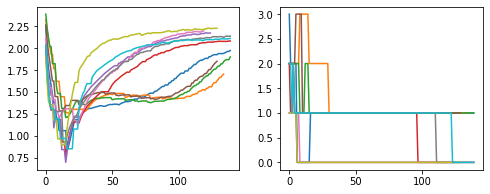

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (8,3))

for trial in range(n_trials):
    axs[0].plot(range(len(err_trials[trial])), err_trials[trial])
    axs[1].plot(range(len(shd_trials[trial])), shd_trials[trial])
    
shd_finals = [shd_trials[i][-1] for i in range(n_trials)]
err_finals = [err_trials[i][-1] for i in range(n_trials)]
print("{:0.4f} +- {:0.4f}".format(np.mean(shd_finals), np.std(shd_finals)))
print("{:0.4f} +- {:0.4f}".format(np.mean(err_finals), np.std(err_finals)))
pass;

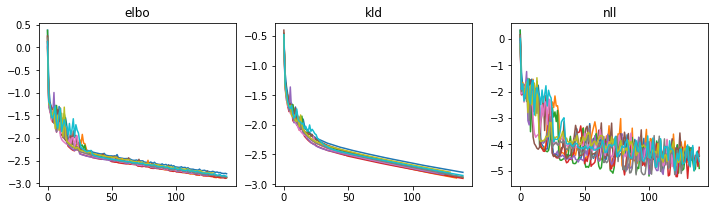

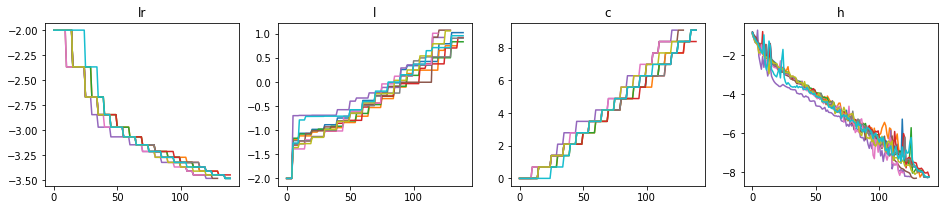

In [13]:
fig, axs = plt.subplots(1, 3, figsize = (12,3))

for i, (k,v) in enumerate(loss_log.items()):
    axs[i].set_title(r'%s'%k)
    for trial in range(n_trials):
        axs[i].plot(range(len(v[trial])), np.log10(v[trial]))
plt.show()

fig, axs = plt.subplots(1, 4, figsize = (16,3))

for i, (k,v) in enumerate(param_log.items()):
    axs[i].set_title(r'%s'%k)
    for trial in range(n_trials):
        axs[i].plot(range(len(v[trial])), np.log10(v[trial]))
pass;

In [14]:
# fig, axs = plt.subplots(1, 4, figsize = (16,3))

# for trial in range(n_trials):
#     axs[0].plot(range(len(lr_trials[trial])), np.log10(lr_trials[trial]))
#     axs[1].plot(range(len(cA_trials[trial])), np.log10(cA_trials[trial]))
#     axs[2].plot(range(len(hA_trials[trial])), np.log10(hA_trials[trial]))
#     axs[3].plot(range(len(lam_trials[trial])), np.log10(lam_trials[trial]))
# pass;

In [15]:
# fig, axs = plt.subplots(1, 5, figsize = (15,3))

# for trial in range(n_trials):
#     axs[0].plot(range(len(err_trials[trial])), err_trials[trial])
#     axs[1].plot(range(len(shd_trials[trial])), shd_trials[trial])
#     axs[2].plot(range(len(kl_trials[trial])), np.log10(kl_trials[trial]))
#     axs[3].plot(range(len(nll_trials[trial])), np.log10(nll_trials[trial]))
#     axs[4].plot(range(len(elbo_trials[trial])), np.log10(elbo_trials[trial]))
# pass;

# shd_finals = [shd_trials[i][-1] for i in range(n_trials)]
# err_finals = [err_trials[i][-1] for i in range(n_trials)]
# print("%s +- %s"%(np.around(np.mean(shd_finals), 3), np.around(np.std(shd_finals), 3)))
# print("%s +- %s"%(np.around(np.mean(err_finals), 3), np.around(np.std(err_finals), 3)))

In [16]:
blah

NameError: name 'blah' is not defined

## SEM Evaluation

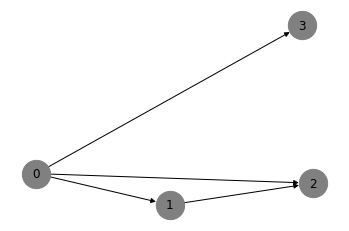

In [23]:
g_learned = SpaceTime.from_adjacency(optimizerL.show_adj(mod_params.graph_threshold))
g_learned.draw_graph()

In [27]:
autoencoder.eval()

data = next(iter(test_loader))[0].double()
noise, _, Wa_train = autoencoder.encode(data)
preds = autoencoder.decode(noise, g_learned.torch_graph(), Wa_train)
pass;

In [28]:
X_train = NodeData(g.data, bins=10)
Z_learned = NodeData(noise.detach().numpy(), bins=10)
X_learned = NodeData(preds.detach().numpy(), bins=10)

pX_train = GraphSampler(g, X_train)
pZ_learned = GraphSampler(g_learned, Z_learned)
pX_learned = GraphSampler(g_learned, X_learned)

In [29]:
Z_resampled_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000), bins = Z_learned.edges())
Z_resampled_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000), bins = Z_learned.edges())

Fit joint KDE for (0,) in 0.0002224445343017578 seconds
Computed joint distro for (0,) in 0.010986089706420898 seconds
Fit conditional KDE for 1 wrt (0,) in 0.000621795654296875 seconds
Computed conditional distro for 1 wrt (0,) in 0.13277196884155273 seconds
Fit conditional KDE for 2 wrt (0, 1) in 0.00027370452880859375 seconds
Computed conditional distro for 2 wrt (0, 1) in 2.5537352561950684 seconds
Fit conditional KDE for 3 wrt (0,) in 0.00048613548278808594 seconds
Computed conditional distro for 3 wrt (0,) in 0.1561110019683838 seconds
Computed joint distro for (0,) in 0.004465818405151367 seconds
Computed conditional distro for 1 wrt (0,) in 0.12883400917053223 seconds
Computed conditional distro for 2 wrt (0, 1) in 2.257539987564087 seconds
Computed conditional distro for 3 wrt (0,) in 0.14113497734069824 seconds


In [30]:
pZ_resampled_cdf = GraphSampler(g_learned, Z_resampled_cdf)
pZ_resampled_pdf = GraphSampler(g_learned, Z_resampled_pdf)

In [39]:
preds_resampled_cdf = autoencoder.decode(g_learned.torch_data(Z_resampled_cdf.data()).double(), g_learned.torch_graph(), Wa_train)
preds_resampled_pdf = autoencoder.decode(g_learned.torch_data(Z_resampled_pdf.data()).double(), g_learned.torch_graph(), Wa_train)
X_resampled_cdf = NodeData(preds_resampled_cdf.detach().numpy(), bins=15)
X_resampled_pdf = NodeData(preds_resampled_pdf.detach().numpy(), bins=15)

pX_resampled_cdf = GraphSampler(g_learned, X_resampled_cdf)
pX_resampled_pdf = GraphSampler(g_learned, X_resampled_pdf)

In [43]:
col_plot_dict

{0: (2, 1), 1: (2, 0), 2: (3, 0), 3: (1, 0)}

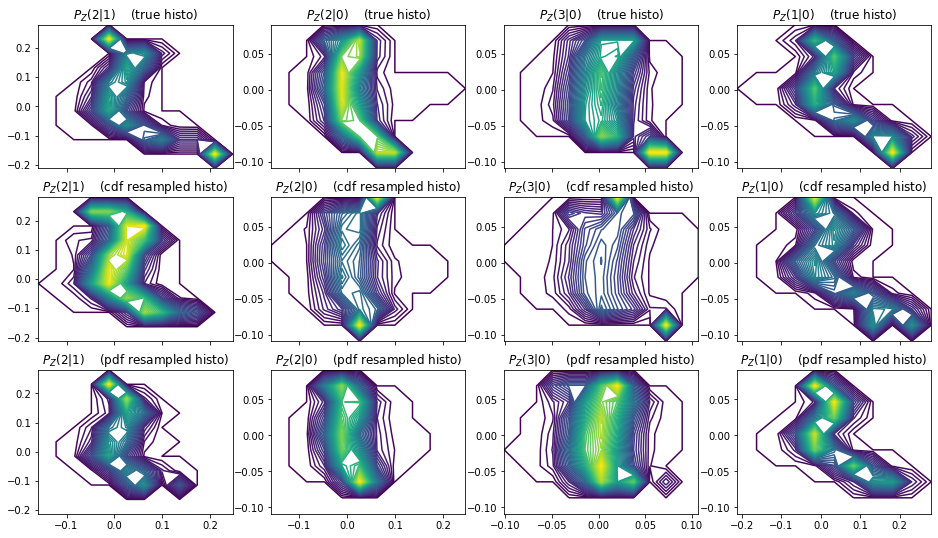

In [44]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_Z(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pZ_learned.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_Z(%s|%s)$    (cdf resampled histo)'%(d,c))
    axs[1][col].contour(*pZ_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pZ_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

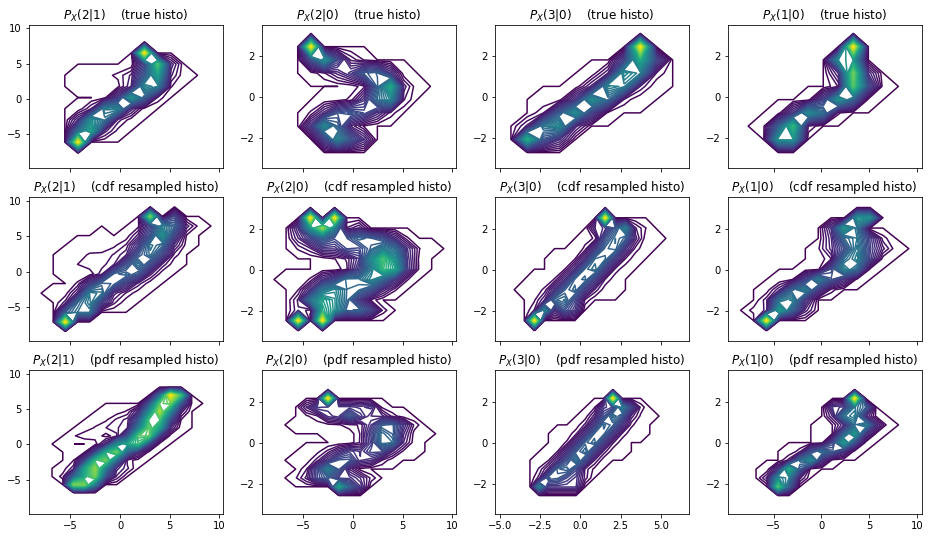

In [45]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(d,c))
    axs[1][col].contour(*pX_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
# plt.plot(pX_train.node_data.axes(0)[0], pX_train.histogram.compute_joint(0)[1])
# plt.plot(pX_train.node_data.axes(1)[0], pX_train.histogram.compute_joint(1)[1])
# plt.show()
# plt.plot(pX_mutil.node_data.axes(0)[0], pX_mutil.histogram.compute_joint(0)[1])
# plt.plot(pX_mutil.node_data.axes(1)[0], pX_mutil.histogram.compute_joint(1)[1])
# pass;

In [ ]:
# truth = pX.histogram.compute_conditional(4,(2,))[1]
# generated = pX_new.histogram.compute_conditional(4,(2,))[1]
# _, truth_ = pX.histogram._epsilonize((), truth)
# _, generated_ = pX.histogram._epsilonize((), generated)
# np.sum(truth_*np.log((truth_/generated_)))/np.prod(truth.shape)

In [ ]:
# np.sum(truth)
# np.sum(truth_*np.log((truth_/generated_)), axis=0, keepdims=True)
# np.exp(np.sum(-truth_*np.log((truth_/(truth_*0.1)))))

## Graph Mutilation Tests

In [47]:
g_mutil = spacetime_mutilator(g, mutilate=[mutilate])
g_mutil.data = Simulator.sem(graph=g_mutil.graph, n=10000, x_dims=sim_params.x_dims, 
                       sem_type=sim_params.sem_noise, linear_type=sim_params.sem_type, 
                       noise_scale=sim_params.noise_scale, seed=sim_params.seed)

simulating 10000 samples from a linear-gauss sem with nonlinear_2 causal effects


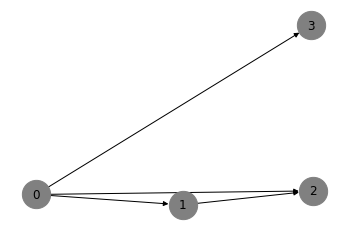

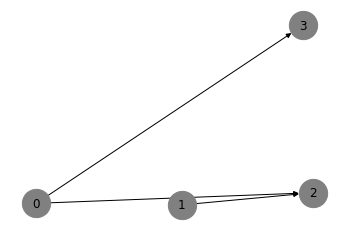

In [48]:
g_learned.draw_graph()

g_learned_mutil = spacetime_mutilator(g_learned, mutilate=[mutilate])
g_learned_mutil.draw_graph()

In [49]:
X_mutil = NodeData(g_mutil.data, bins=10)
pX_mutil = GraphSampler(g, X_mutil)

In [50]:
Z_resampled_mutil_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
Z_resampled_mutil_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
pZ_resampled_mutil_cdf = GraphSampler(g_learned, Z_resampled_mutil_cdf)
pZ_resampled_mutil_pdf = GraphSampler(g_learned, Z_resampled_mutil_pdf)

Fit joint KDE for (1,) in 0.00023055076599121094 seconds
Computed joint distro for (1,) in 0.005091428756713867 seconds
Computed joint distro for (1,) in 0.005056858062744141 seconds


In [51]:
preds_resampled_mutil_cdf = autoencoder.decode(g_learned_mutil.torch_data(Z_resampled_mutil_cdf.data()).double(), 
                                       g_learned_mutil.torch_graph(), Wa_train)
preds_resampled_mutil_pdf = autoencoder.decode(g_learned_mutil.torch_data(Z_resampled_mutil_pdf.data()).double(), 
                                       g_learned_mutil.torch_graph(), Wa_train)
X_resampled_mutil_cdf = NodeData(preds_resampled_mutil_cdf.detach().numpy(), bins=X_learned.edges())
X_resampled_mutil_pdf = NodeData(preds_resampled_mutil_pdf.detach().numpy(), bins=X_learned.edges())
pX_resampled_mutil_cdf = GraphSampler(g_learned_mutil, X_resampled_mutil_cdf)
pX_resampled_mutil_pdf = GraphSampler(g_learned_mutil, X_resampled_mutil_pdf)

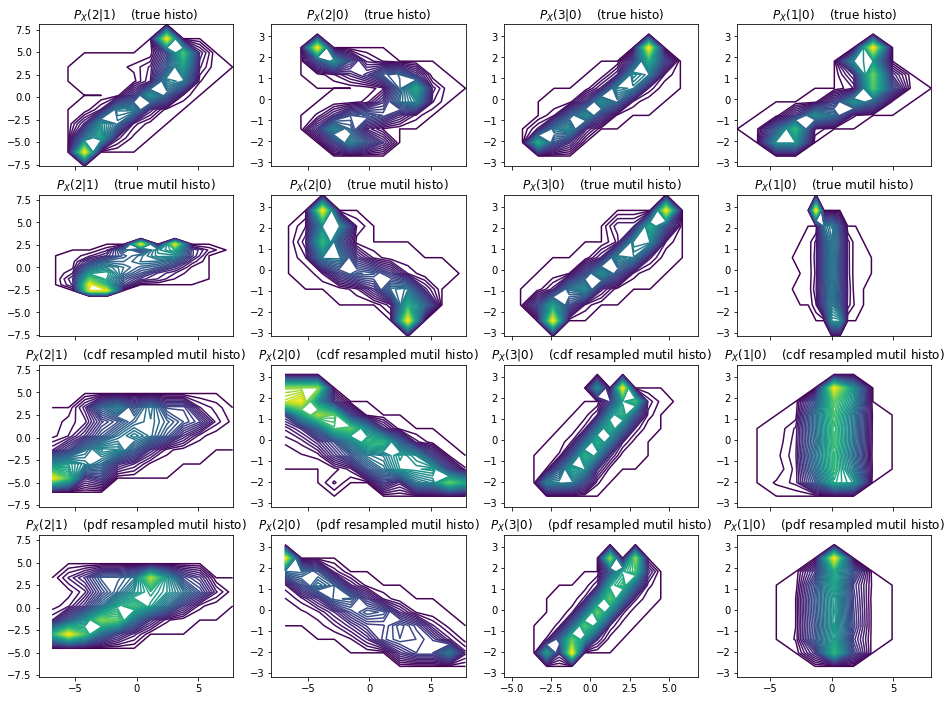

In [52]:
fig, axs = plt.subplots(4, 4, sharex='col', sharey='col', figsize = (16,12))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(d,c))
    axs[1][col].contour(*pX_mutil.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_mutil_cdf.get_contour_conditional(d,c), levels=50)
    axs[3][col].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(d,c))
    axs[3][col].contour(*pX_resampled_mutil_pdf.get_contour_conditional(d,c), levels=50)
    
pass;

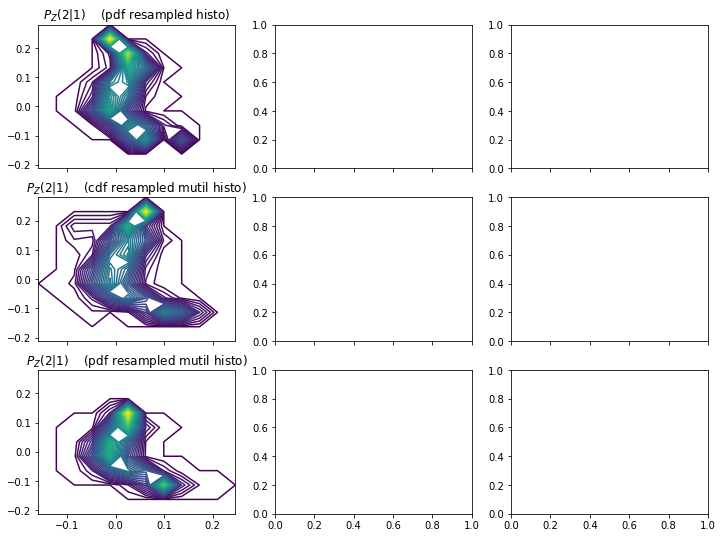

In [53]:
fig, axs = plt.subplots(3, 3, sharex='col', sharey='col', figsize = (12,9))

axs[0][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[0][0].contour(*pZ_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_Z(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][0].contour(*pZ_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][0].contour(*pZ_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)
pass;

In [54]:
def Pi_UNj_DOk(i, j, k, histogram):
    do = np.zeros(histogram.compute_joint(i, k)[1].shape)
    latent = histogram.compute_joint(j)[1]
    
    for n in range(len(latent)):
        do += histogram.compute_conditional(i,(j,k))[1][:,n,:]*latent[n]
    return do

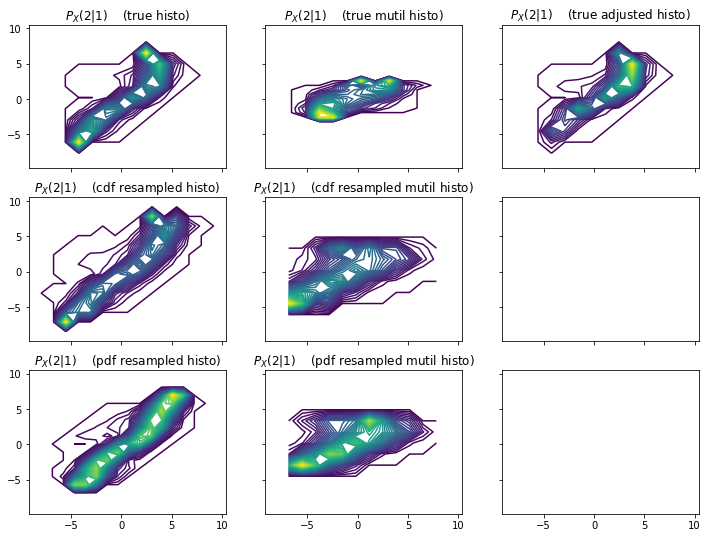

In [55]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (12,9))
axs[0][0].set_title(r'$P_X(%s|%s)$    (true histo)'%(observe,mutilate))
axs[0][0].contour(*pX_train.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(observe,mutilate))
axs[1][0].contour(*pX_resampled_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[2][0].contour(*pX_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)

axs[0][1].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(observe,mutilate))
axs[0][1].contour(*pX_mutil.get_contour_conditional(observe,mutilate), levels=50)
axs[1][1].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][1].contour(*pX_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][1].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][1].contour(*pX_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)



axs[0][2].set_title(r'$P_X(%s|%s)$    (true adjusted histo)'%(observe,mutilate))
axs[0][2].contour(*np.meshgrid(*pX_train.node_data.axes(observe,mutilate)), 
                  Pi_UNj_DOk(observe,latent,mutilate, pX_train.histogram).T, levels=50)
pass;